In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [13]:
!mkdir -p drive
!google-drive-ocamlfuse drive

import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

import os
%cd /content/drive/Colab/
%ls
!pip install imagecodecs

/content/drive/Colab
 data/      run               t001_predict.tif                      unet/
 drive/     run（副本）      'Task1 Detect and Track Cells.ipynb'
 predict/   t000_marker.tif   test.mp4


# **import list**

In [8]:
import sys 
print("python version:%s"% sys.version)

python version:3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [71]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import skimage.io as io
import skimage.transform as trans

from math import sqrt

In [46]:
raw_path = '/content/drive/Colab/data/DIC-C2DH-HeLa/Sequence 1/'
save_path = '/content/drive/Colab/res/'

# **use Unet and masks to train model**

## get eroded masks

In [21]:
def mask_erosion(img):
  gray_set = set()
  w,h = img.shape[0], img.shape[1]
  for i in range(w):
    for j in range(h):
      if img[i][j] !=0:
        gray_set.add(img[i][j])
  gray_set = list(gray_set)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(27,27))
  out = np.zeros((w,h),int)
  gray_cells = []

  for gray_value in gray_set:
    temp_img = np.zeros((w,h),int)
    for i in range(w):
      for j in range(h):
        if img[i][j] == gray_value:
          temp_img[i][j] = gray_value

    erosion = cv2.erode(temp_img.astype(np.uint8),kernel,iterations= 1)

    for m in range(w):
      for n in range(h):
        if erosion[m][n] !=0:
          out[m][n] = erosion[m][n]
  return out

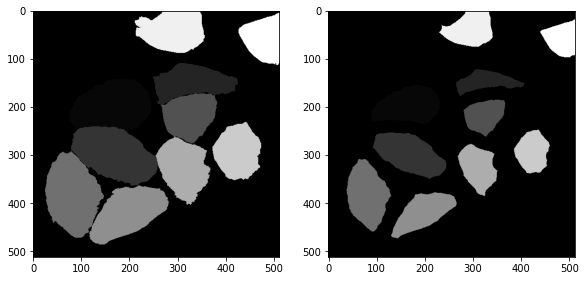

In [20]:
# result display
img = cv2.imread('/content/drive/Colab/data/DIC-C2DH-HeLa-train/01_ST/SEG/man_seg000.tif',-1)
img_erosion = mask_erosion(img)
cv2.imwrite('/content/drive/Colab/t000_marker.tif',img_erosion)

plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(img,'gray')
plt.subplot(132)
plt.imshow(img_erosion,'gray')
plt.show()

In [ ]:
# get all eroded masks of the sequence 1
mask_path = '/content/drive/Colab/data/DIC-C2DH-HeLa-train/01_ST/SEG'
mask_data = np.asarray(list(io.ImageCollection(mask_path + '/man_seg*.tif')))
print(mask_data.shape)

save_path = '/content/drive/Colab/data/DIC-C2DH-HeLa-train/01_marker'
for i in range(mask_data.shape[0]):
  num = str(1000+i)
  img = mask_data[i]
  img_erosion = mask_erosion(img)
  cv2.imwrite(save_path + '/t' + num[1:] +'_marker.tif', img_erosion)

print("done")

## train model

In [ ]:
%cd /content/drive/Colab/unet/
!python3 train.py
print("model saved!")
%cd /content/drive/Colab/

## predict

/content/drive/Colab/unet
6.7713877e-12
0.99993455


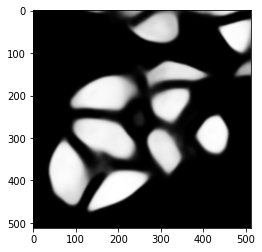

84


In [22]:
%cd /content/drive/Colab/unet/
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from data import get_train_val

images, labels = get_train_val(split=0) # train
test_images = get_train_val(data='test')

model_fname = 'DIC_track_new.h5'
model = keras.models.load_model(model_fname)

probs_marker1 = np.squeeze(model.predict(test_images[:84]))

print(np.amin(probs_marker1)) # lowest prob
print(np.amax(probs_marker1)) # highest prob

plt.imshow(probs_marker1[0], 'gray')
plt.show()
print(len(probs_marker1))

In [47]:
# save predition numpy
np.save(save_path + "s1_pre.npy", probs_marker1)
print("prediection saved!")
# ld = np.load("filename.npy")
print(probs_marker1.shape)
print(probs_marker1[0])

prediection saved!
(84, 512, 512)
[[5.06505370e-03 9.43839550e-04 1.95145607e-04 ... 4.87923920e-02
  7.49827623e-02 1.21234655e-01]
 [6.55949116e-04 2.55823135e-04 5.14846652e-05 ... 3.36295366e-02
  4.85430062e-02 8.45198333e-02]
 [1.61588192e-04 6.69114379e-05 1.00699890e-05 ... 2.05190182e-02
  2.97918320e-02 5.68713248e-02]
 ...
 [1.84080005e-03 1.41984224e-03 4.62502241e-04 ... 1.18523247e-04
  3.91095877e-04 2.57146358e-03]
 [6.23914599e-03 5.23066521e-03 2.54082680e-03 ... 8.33481550e-04
  1.92880630e-03 8.81218910e-03]
 [3.25483382e-02 2.27352083e-02 1.09036267e-02 ... 2.54094601e-03
  5.14274836e-03 2.34291553e-02]]


In [48]:
# save raw image numpy
raw_data_save = np.asarray(list(io.ImageCollection(raw_path + '*.tif')))
np.save(save_path + "s1_raw.npy", raw_data_save)
print(raw_data_save.shape)
print(raw_data_save[0])

(84, 512, 512)
[[132 128 128 ... 126 131 126]
 [125 136 136 ... 112 119 112]
 [124 134 127 ... 118 116 123]
 ...
 [127 127 126 ... 130 132 126]
 [132 130 132 ... 133 127 131]
 [128 131 127 ... 126 132 131]]


## save predicted images(optional)

In [ ]:
import skimage.io as io
import skimage.transform as trans

def save_img(prob_array, save_path, img_num, first_index):
  for i in range(img_num):
    if 0<=i<=9:
      io.imsave(os.path.join(save_path+"t00"+str(i)+"_marker.tif"),prob_array[first_index+i])
    elif 10<=i<=99:
      io.imsave(os.path.join(save_path+"t0"+str(i)+"_marker.tif"),prob_array[first_index+i])
    elif i>=100:
      io.imsave(os.path.join(save_path+"t"+str(i)+"_marker.tif"),prob_array[first_index+i])

save_img(probs_marker1,"/content/drive/Colab/data/DIC-C2DH-HeLa/predict/try3_m1/",84,0)

# **draw contours**

In [101]:
def draw_contours(img,pre):
  pre_float = np.zeros((img.shape[0],img.shape[1]),float)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      pre_float[i][j] = pre[i][j] *255
  pre_uint = pre_float.astype(np.uint8)


  ret, thresh = cv2.threshold(pre_uint, 127, 255, cv2.THRESH_BINARY)
  contours_raw, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  contours_final = []
  for i in contours_raw:
    if (cv2.contourArea(i)>1000):
      contours_final.append(i)

  out = img.copy()
  contours = contours_final

  contours_appproxPoly = [None]*len(contours)
  bound = [None]*len(contours)
  center = [None]*len(contours)
  radius = [None]*len(contours)

  for i, cnt in enumerate(contours):
    # cv2.approxPolyDP(curve, epsilon, closed[, approxCurve]) → approxCurve
    contours_appproxPoly[i] = cv2.approxPolyDP(cnt, 1, True)
    # cv.BoundingRect(points, update=0) → CvRect
    bound[i] = cv2.boundingRect(contours_appproxPoly[i])
    # cv2.minEnclosingCircle(points) → center, radius
    center[i], radius[i] = cv2.minEnclosingCircle(contours_appproxPoly[i])

  rec = out.copy()

  ellipse_list = []
  for i in range(len(contours)):
    x,y = int(bound[i][0]), int(bound[i][1])
    w,h = int(bound[i][2]), int(bound[i][3])
    cv2.rectangle(rec, (x,y), (x+w,y+h), (0, 0, 255), 2)
    ellipse = cv2.fitEllipse(contours[i])
    ellipse_list.append(ellipse)
    cv2.ellipse(rec, ((x+w//2,y+h//2), (min(h,w),max(h,w)), ellipse[2]), (0, 0, 255), 2)
    

  tex = rec.copy()
  for i,j in zip(contours,range(len(contours))):
      M = cv2.moments(i)
      x,y = int(center[j][0]), int(center[j][1])
      w,h = int(bound[j][2]), int(bound[j][3])
      #cv2.putText(img, text, org, fontFace, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]]) → None
      draw = cv2.putText(tex, str(j), (x,y), 1, 3, (255, 0, 255), 3)

  draw_with_cellnum = cv2.putText(draw, "CellNum: "+str(len(center)), (int(img.shape[0])//50,int(img.shape[1]//17)), 1, 2, (255, 0, 255), 3)
  return draw_with_cellnum, center, bound


In [49]:
raw_data = np.load(save_path + "s1_raw.npy")
pre_data = np.load(save_path + "s1_pre.npy")

frame: 0


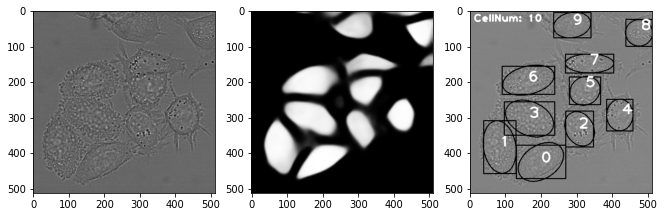

frame: 1


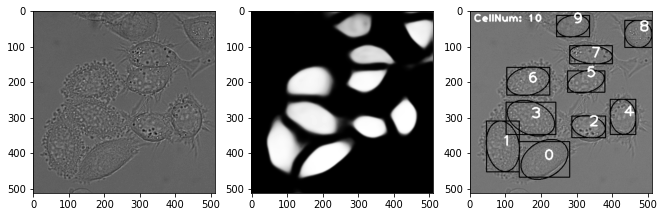

frame: 2


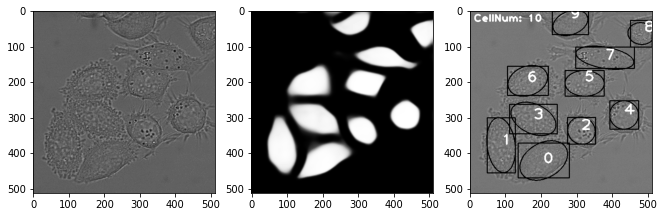

frame: 3


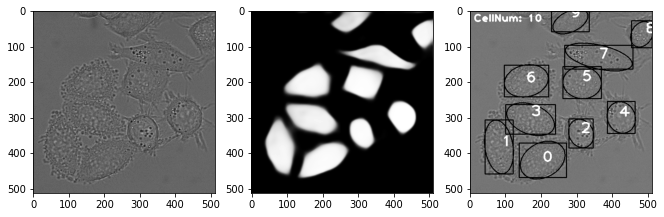

frame: 4


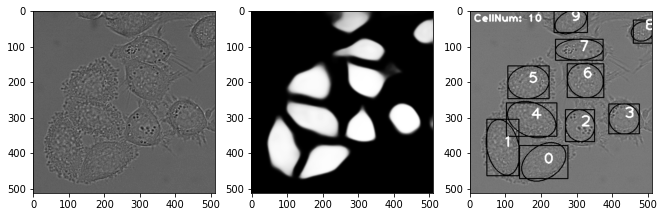

frame: 5


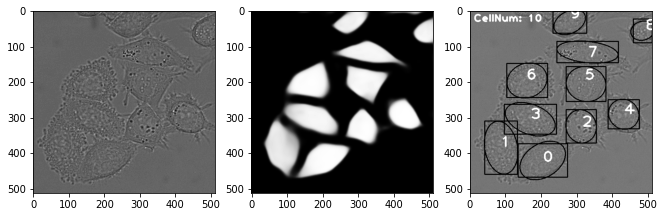

frame: 6


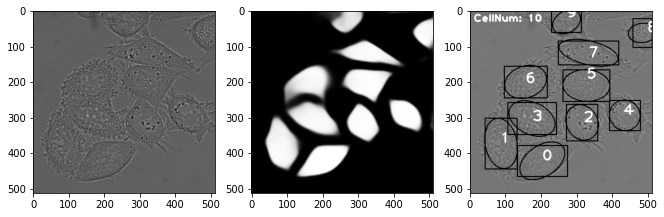

frame: 7


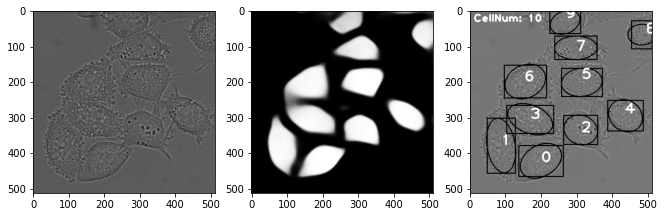

frame: 8


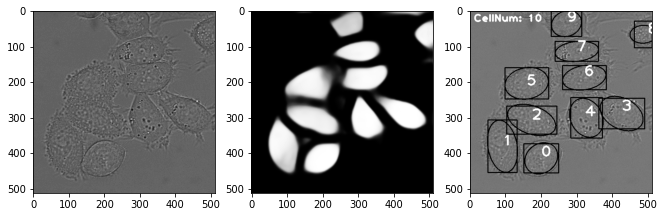

frame: 9


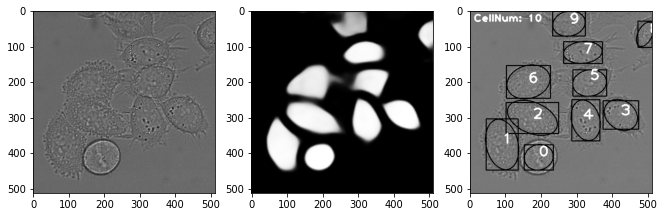

In [102]:
res = {}
for i in range(10):
  img = raw_data[i]
  pre = pre_data[i]

  draw, center, box = draw_contours(img,pre)
  # cv2.imwrite(save_path + '/t' + num[1:] + '_predict.tif',draw)
  res[i] = {}
  res[i]['frame'] = i
  res[i]['draw_img'] = draw
  res[i]['cell_num'] = len(center)
  res[i]['centers'] = center
  res[i]['box'] = box
  

  print("frame:",i)
  #print("centers:",center)
  plt.figure(figsize=(15,8))
  plt.subplot(141)
  plt.imshow(img,'gray')
  plt.subplot(142)
  plt.imshow(pre,'gray')
  plt.subplot(143)
  plt.imshow(draw,'gray')
  # plt.savefig('/content/drive/Colab/predict/try3_s1_plot/t'+ num[1:] + '.jpg')
  plt.show()

In [103]:
print(res)

{0: {'frame': 0, 'draw_img': array([[132, 128, 128, ..., 126, 131, 126],
       [125, 136, 136, ..., 112, 119, 112],
       [124, 134, 127, ..., 118, 116, 123],
       ...,
       [127, 127, 126, ..., 130, 132, 126],
       [132, 130, 132, ..., 133, 127, 131],
       [128, 131, 127, ..., 126, 132, 131]], dtype=uint8), 'cell_num': 10, 'centers': [(199.0, 427.5), (83.0, 382.0), (304.0, 331.0), (165.5, 301.0), (428.199462890625, 291.8681640625), (324.8451232910156, 215.94200134277344), (163.5, 200.5), (335.5, 152.0), (480.3320617675781, 54.90736389160156), (287.55810546875, 39.32640075683594)], 'box': [(130, 377, 139, 94), (38, 308, 91, 149), (269, 281, 78, 101), (96, 255, 142, 94), (384, 248, 74, 89), (279, 185, 88, 78), (90, 155, 148, 79), (268, 121, 136, 53), (438, 23, 74, 76), (235, 4, 105, 71)]}, 1: {'frame': 1, 'draw_img': array([[116, 114, 115, ..., 110, 114, 114],
       [111, 115, 108, ..., 123, 116, 117],
       [109, 109, 122, ..., 112, 120, 121],
       ...,
       [119, 118, 

In [76]:
save_path = "/content/drive/Colab/res/"
np.save(save_path + 's1_draw_res.npy', res) 

# Save
# dictionary = {'hello':'world'}
# np.save('my_file.npy', dictionary) 

# Load
# read_dictionary = np.load('my_file.npy').item()
# print(read_dictionary['hello']) # displays "world"


# **visualize**

In [55]:
def show_video(data, fsize=(512, 512), save=False, fname=None, fps=10):
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(fname, fourcc, fps, fsize, isColor=False)
    out.open(fname, fourcc, fps, fsize, isColor=False)
    for i, frame in enumerate(data):
        if save:
            out.write(frame)
        cv2.imshow(f'frame {i}', frame)
        key = cv2.waitKey(0) & 0xFF
        if key == ord('q'):
            break

    out.release()
    cv2.destroyAllWindows()


def show_video_compare(data_list, fsize=(512, 512)):
    for i, imgs in enumerate(zip(*data_list)):
        resized = tuple(cv2.resize(img, (0, 0), fx=0.8, fy=0.8)
                        for img in imgs)
        horiztonal = np.hstack(resized)
        cv2.imshow(f'frame {i}', horiztonal)
        key = cv2.waitKey(0) & 0xFF
        if key == ord('q'):
            break

    cv2.destroyAllWindows()

# show_video_compare([seq1, seq2, ...])
# if __name__ == '__main__':
#     from data import get_seg_data

#     fsize = (512, 512)
#     file_name = 'DIC_seq_02.mp4'
#     seq, label = get_seg_data('ST')
#     seq_1, seq_2 = seq[:84], seq[84:]
#     show_video(seq_1)

In [ ]:
image_path = '/content/drive/Colab/data/DIC-C2DH-HeLa_raw/Sequence 1'
image_data = np.asarray(list(io.ImageCollection(image_path + '/t*.tif')))

video_path = '/content/drive/Colab/video.avi'
video_fps = 10
video_size = (512,512)
video_type = cv2.VideoWriter_fourcc(*'XVID')

writer = cv2.VideoWriter(video_path, video_type, video_fps, video_size, isColor = False)
for i in range(image_data.shape[0]) :
    writer.write(image_data[i])

writer.release()
print('saved')

# **tracking**
判断是同一个的feature：
1. 面积重叠（面积是否相近）
2. 找一个未匹配的最近的点


In [73]:
draw_data_dict = np.load(save_path + 's1_draw_res.npy',allow_pickle=True).item()
print(draw_data_dict[5])

{'frame': 5, 'draw_img': array([[132, 128, 128, ..., 126, 131, 126],
       [125, 136, 136, ..., 112, 119, 112],
       [124, 134, 127, ..., 118, 116, 123],
       ...,
       [127, 127, 126, ..., 130, 132, 126],
       [132, 130, 132, ..., 133, 127, 131],
       [128, 131, 127, ..., 126, 132, 131]], dtype=uint8), 'centers': [(199.0, 427.5), (83.0, 382.0), (304.0, 331.0), (165.5, 301.0), (428.199462890625, 291.8681640625), (324.8451232910156, 215.94200134277344), (163.5, 200.5), (335.5, 152.0), (480.3320617675781, 54.90736389160156), (287.55810546875, 39.32640075683594)]}


In [104]:
def overlapoverlap(box1, box2):
  endx = max(box1[0] + box1[2], box2[0] + box2[2])
  startx = min(box1[0], box2[0])
  width = box1[2] + box2[2] - (endx - startx)

  endy = max(box1[1] + box1[3], box2[1] + box2[3])
  starty = min(box1[1], box2[1])
  height = box1[3] + box2[3] - (endy - starty)

  if (width <= 0 or height <= 0):
      return 0
  else:
      Area = width * height
      Area1 = box1[2] * box1[3]
      Area2 = box2[2] * box2[3]
      ratio = Area / (Area1 + Area2 - Area)

      return ratio

In [107]:
def tracking_cells():
  track_types = {"BOOSTING":cv2.TrackerBoosting_create, "MIL":cv2.TrackerBoosting_create, \
               "KCF":cv2.TrackerBoosting_create, "TLD":cv2.TrackerBoosting_create, \
               "MEDIANFLOW":cv2.TrackerBoosting_create, "GOTURN":cv2.TrackerBoosting_create, \
               "MOSSE":cv2.TrackerBoosting_create, "CSRT":cv2.TrackerBoosting_create}
  multitracker = track_types['KCF']()

  for 

In [109]:
tracking_cells()

{'BOOSTING': <built-in function TrackerBoosting_create>, 'MIL': <built-in function TrackerBoosting_create>, 'KCF': <built-in function TrackerBoosting_create>, 'TLD': <built-in function TrackerBoosting_create>, 'MEDIANFLOW': <built-in function TrackerBoosting_create>, 'GOTURN': <built-in function TrackerBoosting_create>, 'MOSSE': <built-in function TrackerBoosting_create>, 'CSRT': <built-in function TrackerBoosting_create>}


In [111]:

track_types = {"BOOSTING":cv2.TrackerBoosting_create, "MIL":cv2.TrackerBoosting_create, \
               "KCF":cv2.TrackerBoosting_create, "TLD":cv2.TrackerBoosting_create, \
               "MEDIANFLOW":cv2.TrackerBoosting_create, "GOTURN":cv2.TrackerBoosting_create, \
               "MOSSE":cv2.TrackerBoosting_create, "CSRT":cv2.TrackerBoosting_create}
multitracker = track_types['KCF']()

for i in range(len(draw_data_dict)):
  print(i)

0
1
2
3
4
5
6
7
8
9
